In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from astroML.plotting.tools import draw_ellipse
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

# Recovering MLB pitch type using clustering algorithms
In this noteook we will use the following algorithms
 - KMeans
 - GMM
 
## The data
The data used here are for the Chicago Cubs through the entire 2016 season. That data are split in to two section, before the all star break, and after the all star break. This was done done to use the before dataset as a training set, and the after dataset as a test set.

The datawere scrapped using the [`pybaseball`](https://github.com/jldbc/pybaseball) package

## Main goals:
  1. Can cluster techniques recover the pitch type clusters in the training data
  2. Can a model be used to label pitches in training data
  
## Pitch attributes used
MLB pitches are typically labeled based on their horizontal and vertical movement after leaving the pitchers hand, and the speed of the pitch. We will use these 3 attributes of every pitch when building the model. In the data they are the following:

 - `pfx_x`: movement in `x` in feet
 - `pfx_z`: movement in `y` in feet
 - `release_speed`: speed of pitch as it left the picters hand

In [2]:
# Read before data into pandas dataframe
before_asb = pd.read_csv('all_before_asb.csv')

In [3]:
# Read after data into pandas dataframe
after_asb = pd.read_csv('all_after_asb.csv')

In [4]:
#Concant the two dataframes into a single dataframe
full_season = pd.concat([before_asb,after_asb])

## Split handedness of pitcher
Before we start clustering the data, we have to split it based on the handedness of the pitcher. For a given pitch type, the spatial characteristics of how the ball is thrown will be a mirror image when going from a right handed pitcher to a left handed pitcher.

The dataframes have a column `p_throws` so it is each to split into right and left.

In [5]:
full_season_right = full_season[full_season.p_throws == 'R']

In [6]:
full_season_left = full_season[full_season.p_throws == 'L']

## Plot right hand pitches and left hand pitches

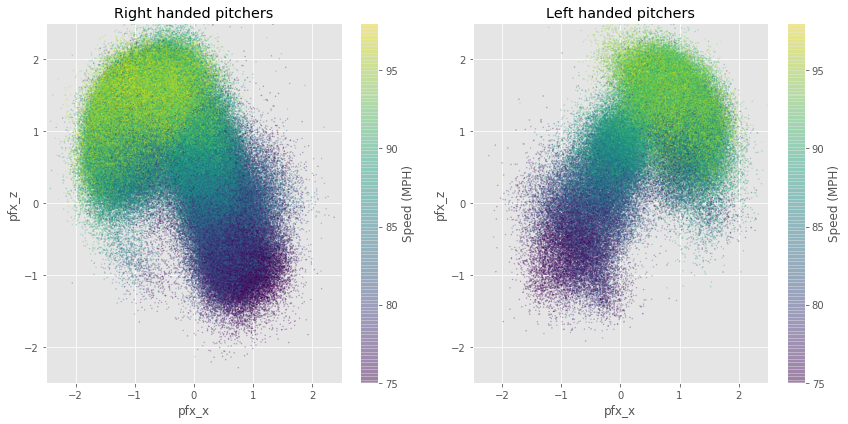

In [67]:
plt.figure(figsize=(12,6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
# ax1.plot(full_season_right.pfx_x,full_season_right.pfx_z,',')
speed1 = ax1.scatter(full_season_right.pfx_x,full_season_right.pfx_z,c = full_season_right.release_speed,
                  s=1,alpha=0.25,vmin=75,vmax=98)
cb1 = plt.colorbar(speed1,ax=ax1)
cb1.set_label('Speed (MPH)')
# ax2.plot(full_season_left.pfx_x,full_season_left.pfx_z,',')
speed2 = ax2.scatter(full_season_left.pfx_x,full_season_left.pfx_z,c = full_season_left.release_speed,
                  s=1,alpha=0.25,vmin=75,vmax=98)
cb2 = plt.colorbar(speed2,ax=ax2)
cb2.set_label('Speed (MPH)')
ax1.set_xlabel('pfx_x')
ax1.set_ylabel('pfx_z')
ax1.set_title('Right handed pitchers')
ax2.set_xlabel('pfx_x')
ax2.set_ylabel('pfx_z')
ax2.set_title('Left handed pitchers')
ax1.set_xlim(-2.5,2.5)
ax2.set_xlim(-2.5,2.5)
ax1.set_ylim(-2.5,2.5)
ax2.set_ylim(-2.5,2.5)
plt.tight_layout()
plt.savefig('pitch_movement.png',dpi=200)

In [8]:
def pitch_select(input_df, pitch_names = None):
    """
    function to filter a dataframe based on desired pitches.
    
    this function also filters out any pitches that are balls as they
    could be large spatial outliers.
    """
    if pitch_names is None:
        pitch_names = ['2-Seam Fastball', '4-Seam Fastball', 
                       'Changeup', 'Curveball',
                       'Cutter','Sinker', 'Slider']
    
    keep_pattern_names = '|'.join(pitch_names)
    
    keep_pitches = ['strike','swinging_strike']
    avoid_pitches = ['ball','intent_ball','blocked_ball']
    keep_pattern = '|'.join(keep_pitches)
    avoid_pattern = '|'.join(avoid_pitches)
    
    return input_df[(input_df.pitch_name.str.contains(keep_pattern_names)==True) & 
                    (input_df.description.str.contains(keep_pattern)==True) &
                    (input_df.description.str.contains(avoid_pattern)==False)]

In [25]:
def plot_pitches(input_df, pitch_name, ax = None, **kwargs):
    """
    function to plot the spatial attributes of a pitch.
    
    Only the pitch given by pitch_name will be plotted
    """
    if ax is None:
        ax = plt.subplot(111)
    ax1 = plt.subplot(ax)
#     ax1.plot(input_df[input_df.pitch_name == pitch_name].pfx_x, 
#              input_df[input_df.pitch_name == pitch_name].pfx_z,**kwargs)
    cb = ax1.scatter(input_df[input_df.pitch_name == pitch_name].pfx_x, 
                     input_df[input_df.pitch_name == pitch_name].pfx_z,
                     c = input_df[input_df.pitch_name == pitch_name].release_speed,**kwargs)
    plt.colorbar(cb,ax=ax1)
    ax1.set_xlim(-2.5,2.5)
    ax1.set_ylim(-2.5,2.5)
    return ax1

In [26]:
def make_model_data(input_df,cols = None):
    """
    Produce a ndarry in the correct format to be used in the KMeans and GMM models
    """
    if cols is None:
        cols = ['pfx_x', 'pfx_z','release_speed']
    input_df.dropna(subset=cols,inplace = True)
    X_model = input_df[cols].values.reshape(-1,len(cols))
    return X_model

### Use the `pitch_select` to create a dataframe with the pitches we will try to cluster

In [40]:
pitches_df_right = pitch_select(full_season_right)

In [41]:
pitch_names = ['2-Seam Fastball', '4-Seam Fastball', 
               'Changeup', 'Curveball',
               'Cutter','Sinker', 'Slider']

### Plot each pitch type in its own subplot to see where they fall in the `pfx_x`,`pfx_z` plane.

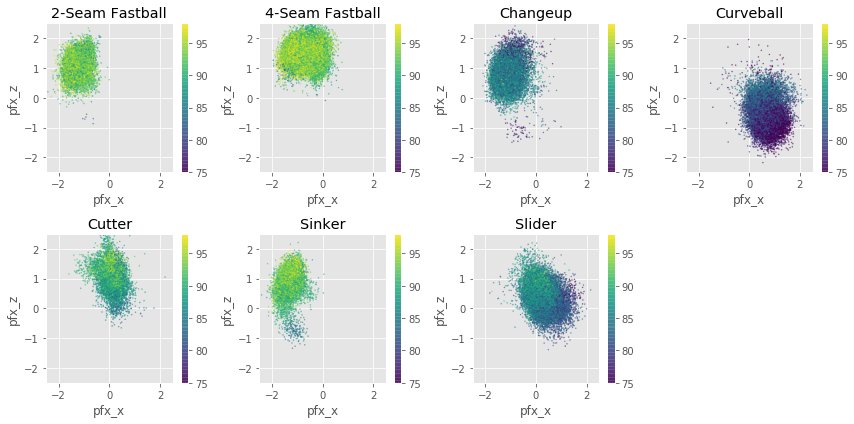

In [42]:
plt.figure(figsize=(12,6))
for i,pn in enumerate(pitch_names):
    ax = 240 + (i+1)
#     a = plot_pitches(pitches_df_right,pn, ax=ax, marker=',', ls ='',c='r')
    a = plot_pitches(pitches_df_right,pn, ax=ax,s=1,alpha=0.5,vmin=75,vmax=98)
    a.set_title(pn)
    a.grid(True)
    a.set_xlabel('pfx_x')
    a.set_ylabel('pfx_z')
plt.tight_layout()
# plt.savegfig()

### Create an ndarry for the training data. To start we are going to use everything to see if we can recover the clusters in the preivous plot.

In [43]:
training_df_right = make_model_data(pitches_df_right)

### Fit a KMeans model to the `training_df_right` data with a 7 cluster model.

In [44]:
kmeans_right = KMeans(n_clusters=7, random_state=0).fit(training_df_right)

### Add the labels assigned by the KMeans model to the `pitches_df_right` dataframe.

In [45]:
pitches_df_right['km_cluster_label'] = kmeans_right.labels_

In [48]:
def plot_pitches_clusters(input_df, cluster_col, cluster_label, ax = None, **kwargs):
    """
    Function to separate and plot the pitches based on how they are labeled by a clustering
    algorithm.
    
    This function also assigns a pitch type to each cluster using a majority vote. That is, 
    the pitch type that is the majority member of a given cluster sets the pitch label for all
    members of that cluster.
    """
    if ax is None:
        ax = plt.subplot(111)
    ax1 = plt.subplot(ax)
#     ax1.plot(input_df[input_df[cluster_col] == cluster_label].pfx_x, 
#              input_df[input_df[cluster_col] == cluster_label].pfx_z,**kwargs)
    
    cb = ax1.scatter(input_df[input_df[cluster_col] == cluster_label].pfx_x, 
                     input_df[input_df[cluster_col] == cluster_label].pfx_z,
                     c = input_df[input_df[cluster_col] == cluster_label].release_speed,**kwargs)
    plt.colorbar(cb,ax=ax1)
    
    name, count = np.unique(input_df[input_df[cluster_col] == cluster_label].pitch_name.values,
                            return_counts=True)
    maxpos = count.argmax()
    
    most_frequent = name[maxpos]
    
    ax1.set_xlim(-2.5,2.5)
    ax1.set_ylim(-2.5,2.5)
    return ax1, most_frequent

### Plot the clusters as labeled by the KMeans algorithm.

As we can see there are some problems. For example, the `4-Seam Fastball` is the majority member of 3 of the 7 clusters. The clusters also do not resemable those in the original training set.

### KMeans recovered pitch types

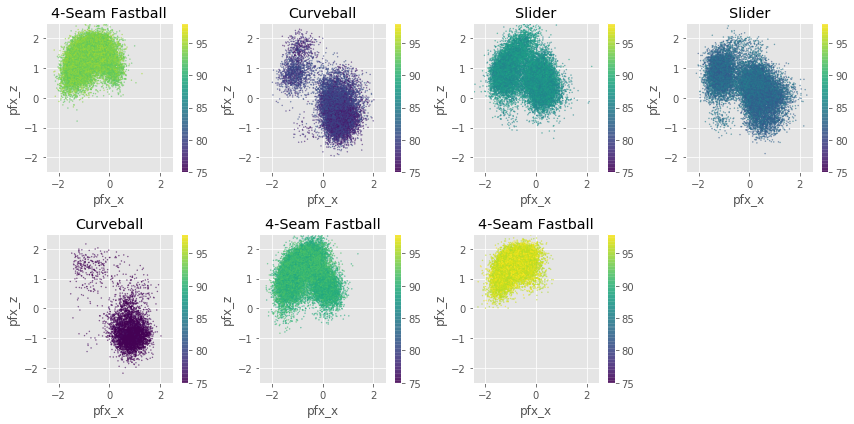

In [50]:
plt.figure(figsize=(12,6))
for i,cl in enumerate(np.unique(kmeans_right.labels_)):
    ax = 240 + (i+1)
#     a, most_frequent  = plot_pitches_clusters(pitches_df_right,'km_cluster_label',cl, ax=ax, 
#                                               marker=',', ls ='',c='r')
    a, most_frequent  = plot_pitches_clusters(pitches_df_right,'km_cluster_label',cl,ax=ax,s=1,alpha=0.5,vmin=75,vmax=98)
    a.set_title(most_frequent)
    a.grid(True)
    a.set_xlabel('pfx_x')
    a.set_ylabel('pfx_z')
plt.tight_layout()

### Actual pitch types

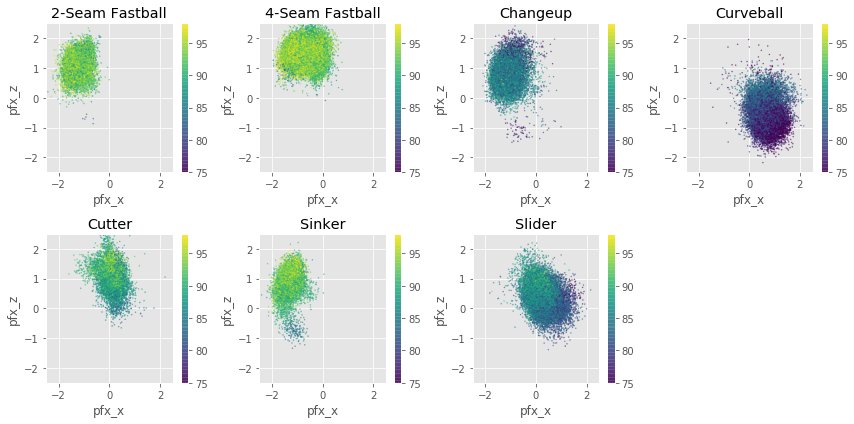

In [51]:
plt.figure(figsize=(12,6))
for i,pn in enumerate(pitch_names):
    ax = 240 + (i+1)
#     a = plot_pitches(pitches_df_right,pn, ax=ax, marker=',', ls ='',c='r')
    a = plot_pitches(pitches_df_right,pn, ax=ax,s=1,alpha=0.5,vmin=75,vmax=98)
    a.set_title(pn)
    a.grid(True)
    a.set_xlabel('pfx_x')
    a.set_ylabel('pfx_z')
plt.tight_layout()

## Try to improve with Gaussian Mixture Models

Used the Akaike information criterion and the Bayesian information criterion to try to pick the right number of GMM components.

Here we start with 3 components and go up to 11 in steps of 1.


In [52]:
aic = []
bic = []
gmm_model_dict = {}
for i,c in enumerate(np.arange(3,12,1)):
    model = GMM(n_components = c,covariance_type='full',
                max_iter=1000, random_state=1234, 
                tol=0.005)
    model.fit(training_df_right)
    bic.append(model.bic(training_df_right))
    aic.append(model.aic(training_df_right))
    gmm_model_dict[c] = model.fit(training_df_right)

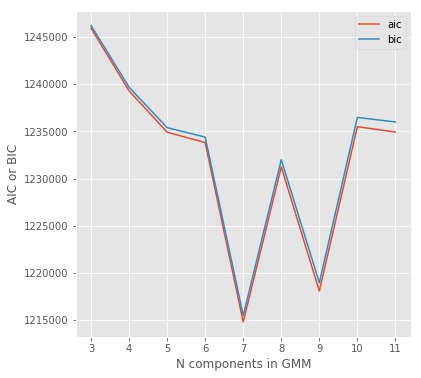

In [53]:
plt.figure(figsize=(6,6))
plt.plot(np.arange(3,12,1),aic,label='aic')
plt.plot(np.arange(3,12,1),bic,label='bic')
plt.xlabel('N components in GMM')
plt.ylabel('AIC or BIC')
plt.legend()

There is a bit of a mimimum at 7, but it is not very convincing. We will still use this as our model.

Next, see if we can recover the pitching type clusters in the training data by assigning each pitch to a component using the calculated GMM.

In [54]:
pitches_df_right['gmm_cluster_label'] = gmm_model_dict[7].predict(training_df_right)

Plot and label the pitch type cluster and determined from the 7 componment GMM.

We can see that we still did not recover all of the pitches, but this is doing better than the Kmeans.

Sinkers and 2-Seam fastballs are considered to be the same pitch in some, so they can be difficult to single out.

The Cutter cluster is also missing, but there were not many pitches of this type in the training set.

### GMM classified pitch types

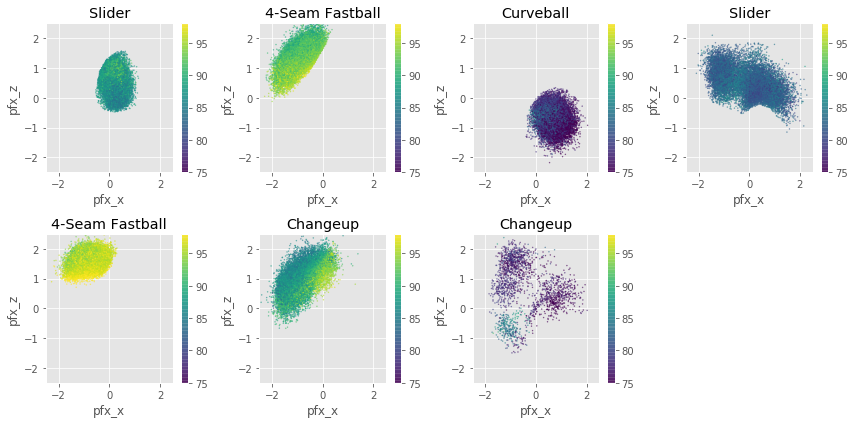

In [57]:
plt.figure(figsize=(12,6))
for i,cl in enumerate(np.unique(pitches_df_right['gmm_cluster_label'])):
    ax = 240 + (i+1)
#     a, most_frequent  = plot_pitches_clusters(pitches_df_right,'gmm_cluster_label',cl, ax=ax, 
#                                               marker=',', ls ='',c='r')
    a, most_frequent  = plot_pitches_clusters(pitches_df_right,'gmm_cluster_label',cl,ax=ax,s=1,alpha=0.5,vmin=75,vmax=98)
    a.set_title(most_frequent)
    a.grid(True)
    a.set_xlabel('pfx_x')
    a.set_ylabel('pfx_z')
plt.tight_layout()

### Plot the entire sample with the component centers and 1.5 sigma levels.

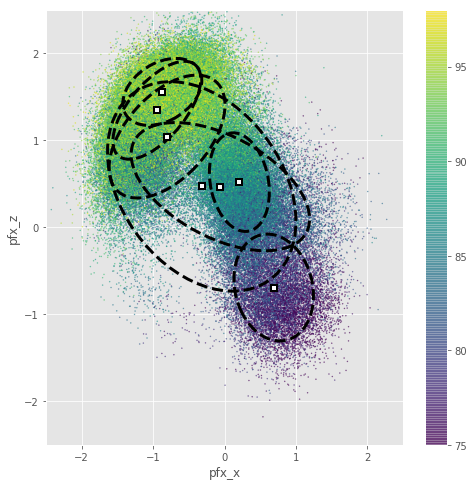

In [59]:
plt.figure(figsize=(8,8))
ax1 = plt.subplot(111)
# ax1.plot(pitches_df_right.pfx_x,pitches_df_right.pfx_z,'o',ms=1,alpha=0.5)
speed = ax1.scatter(pitches_df_right.pfx_x,pitches_df_right.pfx_z,c = pitches_df_right.release_speed,
                  s=1,alpha=0.5,vmin=75,vmax=98)
plt.colorbar(speed,ax=ax1)
for (mu, C, w) in zip(gmm_model_dict[7].means_, 
                      gmm_model_dict[7].covariances_, 
                      gmm_model_dict[7].weights_):
    draw_ellipse(mu, C, scales=[1.5], ax=ax1, fc='none' ,ec='k',lw=3, ls='--')
    ax1.plot(mu[0],mu[1],'ws',mec='k',mew=2)
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.grid(True)
plt.xlabel('pfx_x')
plt.ylabel('pfx_z')

# Use just the before dataset to train the model, then try to recover the pitch type clusters in the after dataset.

In [26]:
before_asb_right = before_asb[before_asb.p_throws == 'R']
after_asb_right = after_asb[after_asb.p_throws == 'R']

In [27]:
before_pitches_df_right = pitch_select(before_asb_right)
after_pitches_df_right = pitch_select(after_asb_right)

In [28]:
training_df_right = make_model_data(before_pitches_df_right)
test_df_right = make_model_data(after_pitches_df_right)

In [29]:
aic = []
bic = []
gmm_model_dict = {}
for i,c in enumerate(np.arange(3,12,1)):
    model = GMM(n_components = c,covariance_type='full',
                max_iter=10000, random_state=1234, 
                tol=0.002)
    model.fit(training_df_right)
    bic.append(model.bic(training_df_right))
    aic.append(model.aic(training_df_right))
    gmm_model_dict[c] = model.fit(test_df_right)

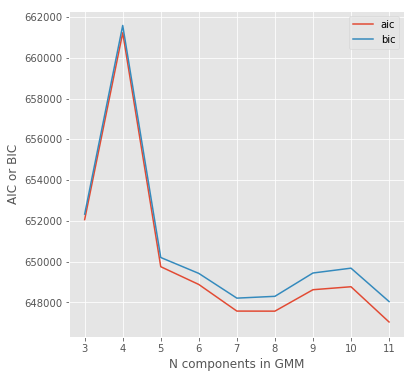

In [30]:
plt.figure(figsize=(6,6))
plt.plot(np.arange(3,12,1),aic,label='aic')
plt.plot(np.arange(3,12,1),bic,label='bic')
plt.xlabel('N components in GMM')
plt.ylabel('AIC or BIC')
plt.legend()

In [31]:
after_pitches_df_right['gmm_cluster_label'] = gmm_model_dict[7].predict(test_df_right)


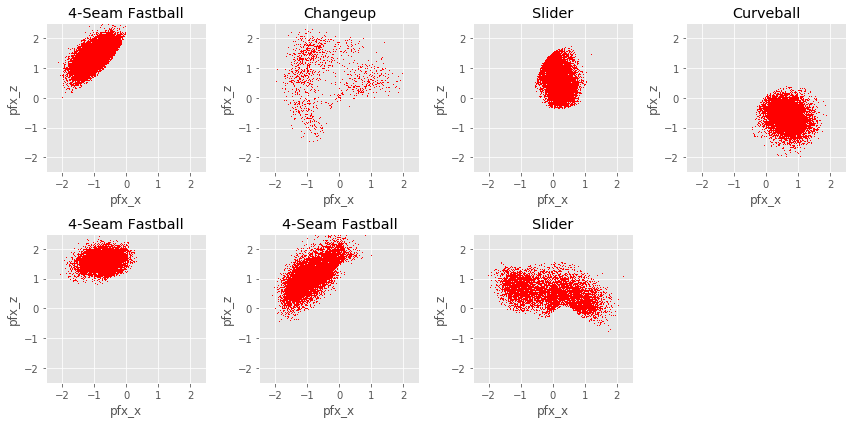

In [32]:
plt.figure(figsize=(12,6))
for i,cl in enumerate(np.unique(after_pitches_df_right['gmm_cluster_label'])):
    ax = 240 + (i+1)
    a, most_frequent  = plot_pitches_clusters(after_pitches_df_right,'gmm_cluster_label',cl, ax=ax, 
                                              marker=',', ls ='',c='r')
    a.set_title(most_frequent)
    a.grid(True)
    a.set_xlabel('pfx_x')
    a.set_ylabel('pfx_z')
plt.tight_layout()

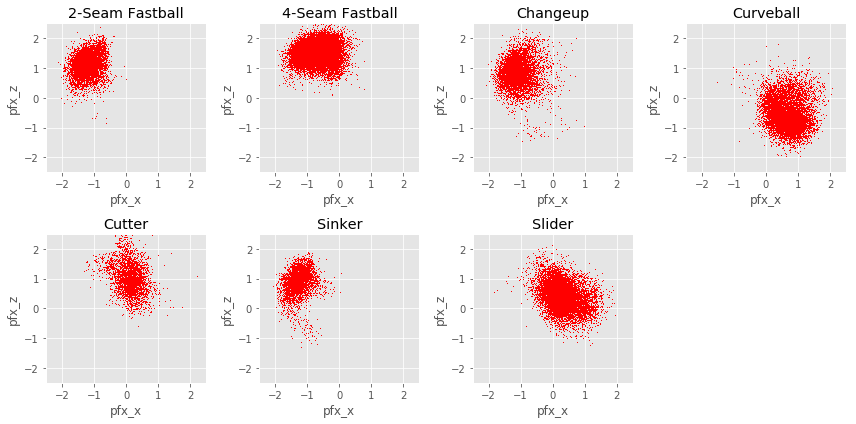

In [33]:
plt.figure(figsize=(12,6))
for i,pn in enumerate(pitch_names):
    ax = 240 + (i+1)
    a = plot_pitches(after_pitches_df_right,pn, ax=ax, marker=',', ls ='',c='r')
    a.set_title(pn)
    a.grid(True)
    a.set_xlabel('pfx_x')
    a.set_ylabel('pfx_z')
plt.tight_layout()

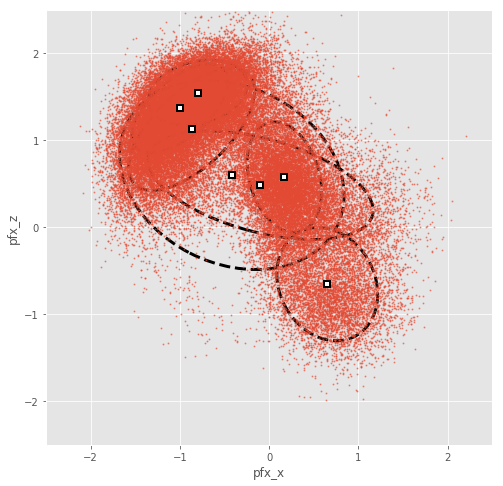

In [34]:
plt.figure(figsize=(8,8))
ax1 = plt.subplot(111)
ax1.plot(after_pitches_df_right.pfx_x,after_pitches_df_right.pfx_z,'o',ms=1,alpha=0.5)
for (mu, C, w) in zip(gmm_model_dict[7].means_, 
                      gmm_model_dict[7].covariances_, 
                      gmm_model_dict[7].weights_):
    draw_ellipse(mu, C, scales=[1.5], ax=ax1, fc='none' ,ec='k',lw=3, ls='--')
    ax1.plot(mu[0],mu[1],'ws',mec='k',mew=2)
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.grid(True)
plt.xlabel('pfx_x')
plt.ylabel('pfx_z')